# 3. Combine the social network and fMRI data

Author: Carolyn Parkinson

Date: August 6, 2018


In this last notebook, we'll relate the distance between individuals in the social network we characterized in Part 1 to region-wise neural response time-series similarities (which were computed in Part 2).


In [1]:
import csv
import igraph
import json
import itertools  
import os
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
study_path = "./data"

In [3]:
def ld_writeDicts(filePath, dict):
    '''
    write dictionaries to files with json encoding
    '''
    f = open(filePath,'w')
    newData = json.dumps(dict, sort_keys = True, indent = 4)
    f.write(newData)
    f.close()
    

def ld_readDicts(filePath):  
    '''
    read dictionaries to json files
    '''
    f = open(filePath, 'r')  
    data = json.loads(f.read())  
    f.close()  
    return data  

First, we'll read in the edge list describing the social network of the cohort

In [4]:
reader = csv.DictReader(open('./data/socialnetworks/anon_edge_list.csv'))

g = igraph.Graph.DictList(vertices = None, 
                          edges = reader,
                          directed = True)


# remove loops (self-nominations)
g = igraph.Graph.simplify(g, loops=True)


# only count mutually reported ties
g_undir = igraph.Graph.as_undirected(g, mode = "mutual")

In [7]:
#print(g_undir)

Read in list of subset of network members for whom we have fMRI data

In [6]:
# load in list of fMRI subjects
with open("./data/fmri/fmri_subjects.json") as data_file:
    subj_list = json.load(data_file)

In [11]:
# make list of all possible subject pairs (N x N)
subj_pairs = list(itertools.product(subj_list, subj_list))

# make an empty list to store only unique (irrespective of order) 
# ID pairs and disregard self-self pairs
unique_subj_pairs = []

for subj_pair in subj_pairs:
    subj_pair_o = tuple(sorted(subj_pair))
    if subj_pair_o not in unique_subj_pairs and subj_pair_o[0] != subj_pair_o[1]:
        unique_subj_pairs.append(subj_pair_o)

In [12]:
# read in the dictionary containing all subjects' time series
all_ts_dict = ld_readDicts("{}/fmri/all_subj_roi_ts.json".format(study_path))

In [13]:
# extract a list of rois
roi_list = list(all_ts_dict[list(all_ts_dict)[0]])

Now make a dictionary store distances between of all pairs of fMRI subjects (with respect to the social network and neural dissimilarity):

In [14]:
dist_dict = {}

for subj_pair in unique_subj_pairs:
            
    dist_dict[subj_pair] = {}

    subj1 = subj_pair[0]
    subj2 = subj_pair[1]
    
    
    # add geodesic distance between these participants in the social network
    soc_dist = igraph.Graph.shortest_paths(g_undir, source = subj1,
                                           target = subj2)[0][0]
    dist_dict[subj_pair]['soc_dist'] = soc_dist
    

    # add correlation distances between ROI response time series
    for roi in roi_list:
        
        # Get time series for each subject
        subj1_ts = all_ts_dict[subj1][roi]
        subj2_ts = all_ts_dict[subj2][roi]

        # if one of the subjects is missing data for this ROI, replace with NaN
        if not subj1_ts or not subj2_ts:
            this_dist = np.nan

        else:            
            X = np.array([subj1_ts, subj2_ts])
            this_dist = distance.pdist(X, metric = "correlation")

        dist_dict[subj_pair][roi] = float(this_dist)     

Now we have a nested dictionary containing a dictionary for each unique pair of participants where we've stored the social distance value for each dyad and the correlation distance between their neural response time series for each ROI.

Now, we'll convert this dictionary to a pandas dataframe for easy plotting

In [15]:
# convert the dictionary to a pandas data frame 
# with a row for each dyad and a column for each distance
dist_df = pd.DataFrame(dist_dict)
dist_df_t = dist_df.transpose()

# replace a given cell's value with the mean of that column if it's NA
dist_df_t = dist_df_t.fillna(dist_df_t.mean())

# we have very few distance 5 dyads, recode to be 4
dist_df_t['soc_dist'] = dist_df_t['soc_dist'].replace(5, 4)

# z-score values within each of the 80 ROIs across dyads
scaler = StandardScaler()
dist_df_t[roi_list] = scaler.fit_transform(dist_df_t[roi_list])

Now average values across dyads in each social distance category for each ROI

In [16]:
# average within levels of social distance
roi_means_by_dist = dist_df_t.groupby("soc_dist").apply(np.mean)

# disregard social distance variable from this summary dataset
roi_means_by_dist = roi_means_by_dist.drop(['soc_dist'], axis = 1)

# sort by similarity within friends and transpose
roi_means_by_dist = roi_means_by_dist.transpose().sort_values(by = 1.0, ascending=True)

# reverse score distances for more intuitive plotting 
# so higher value means more similar instead of more different
roi_mean_sim_by_dist = -roi_means_by_dist

Now let's plot the average response time series similarity for each social distance level(normalized within brain region across all dyads)

Populating the interactive namespace from numpy and matplotlib


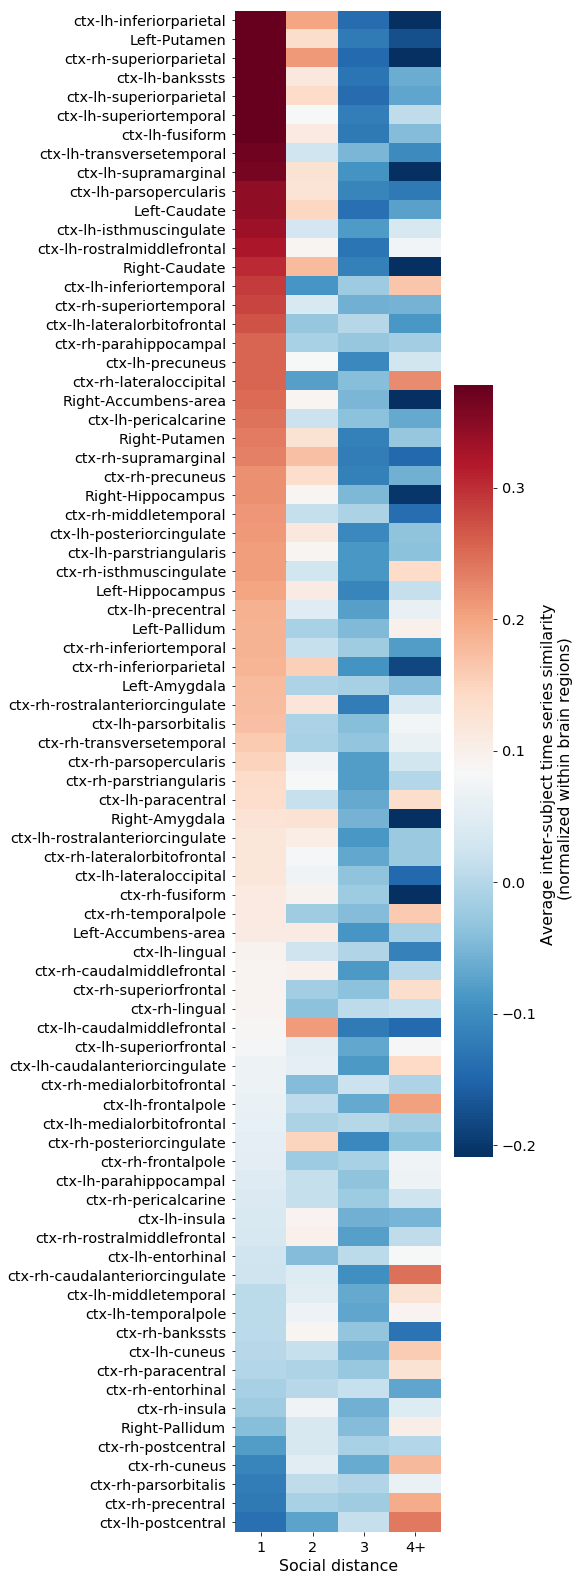

In [17]:
%pylab inline
sns.set_context("paper", font_scale = 1.8)

pylab.rcParams['figure.figsize'] = 8, 22
pylab.rcParams['font.size'] = 8

ax = sns.heatmap(roi_mean_sim_by_dist, 
                 robust=True,
                 cmap="RdBu_r",
                 xticklabels = ['1', '2', '3', '4+'],
                 
                 cbar_kws={'label':'Average inter-subject time series similarity \n (normalized within brain regions)'})

ax.set_xlabel("Social distance")
plt.tight_layout()

#savefig("sim_plot_test.png", dpi=600)


# Permutation testing

We have to be careful when testing for significance here, since the data points are not independent (the same person participates in multiple dyads).  

There are many ways to account for the non-independence of dyad members. Here, we'll focus on a permutation testing approach, where we'll keep the topology of the network the same and randomly shuffle brain data across the network members who participated in the study (i.e. across the red nodes in the diagram we created before):


In [18]:
# create functions to shuffle subj IDs corresponding to each row, 
# and to get correlation distances between each pair of subjects

def shuffle(df):
    """
    Take a dataframe where the columns are ROIs  and the 
    subjects are the rows (row indices = subject IDs),
    and randomly shuffles the row labels.
    """
    
    df2 = df.copy()
    df2['new_id'] = np.random.permutation(df2.index)

    # get rid of added column
    df2.index = (df2['new_id'])
    
    # get rid of index name
    df2.index.name = None

    # Now have Num_subj x Num_ROIs data frame with subject ID randomly shuffled.
    return df2


def get_pairwise_dist(df):
    """
    make a dictionary containing the pairwise distances between
    each pair of people for each brain region
    """
    # make dictionary to store distances between of all  pairs of fMRI subjects
    all_dist_dict = {}

    for subj_pair in unique_subj_pairs:
            
        all_dist_dict[subj_pair] = {}

        subj1 = subj_pair[0]
        subj2 = subj_pair[1]
    
    
        # add geodesic distance between these participants in the social network
        soc_dist = igraph.Graph.shortest_paths(g_undir, 
                                               source = subj1,
                                               target = subj2)[0][0]
        all_dist_dict[subj_pair]['soc_dist'] = soc_dist
    

        # add correlation distances between ROI response time series
        for roi in roi_list:
        
            # Get time series for each subject
            subj1_ts = df[roi].loc[subj1]
            subj2_ts = df[roi].loc[subj2]

            # if one of the subjects is missing data for this ROI, replace with NaN
            if not subj1_ts or not subj2_ts:
                this_dist = np.nan

            else:            
                X = np.array([subj1_ts, subj2_ts])
                this_dist = distance.pdist(X, metric = "correlation")

            all_dist_dict[subj_pair][roi] = float(this_dist)   
     
       
    return all_dist_dict


In [19]:
# create dictionaries to store permuted results
# for each social distance for each ROI
dist_df_t['soc_dist'].unique()

perm_dist_dict = {}

for dist in dist_df_t['soc_dist'].unique():
    perm_dist_dict[dist] = {}

For the sake of time, we'll just start with 10 permutations:

In [20]:
nperm = 10
perm_dist_dict = {}

scaler = StandardScaler()
all_ts_df = pd.DataFrame.from_dict(all_ts_dict).transpose()

for dist in dist_df_t['soc_dist'].unique():
    perm_dist_dict[dist] = {}
    

for n in range(nperm):
    print('perm = {}'.format(n))

    # shuffle row labels (subject IDs) corresponding to neural 
    # time series data to randomly shuffle brain data across 
    # network members
    shuffled_fmri_ts = shuffle(all_ts_df)
    
    # get pairwise distances between shuffled data
    shuffled_dists = get_pairwise_dist(shuffled_fmri_ts)
    
    # make data frame of the shuffled data
    shuffled_dists = pd.DataFrame(shuffled_dists).transpose()
    
    # replace missing data with mean for that ROI
    shuffled_dists = shuffled_dists.fillna(shuffled_dists.mean())
    
    # z-score within region across dyads
    shuffled_dists[roi_list] = scaler.fit_transform(shuffled_dists[roi_list])
    
    # recode distance 5s as 4s (see above)
    shuffled_dists['soc_dist'] = shuffled_dists['soc_dist'].replace(5, 4)

    # mean by social distances
    means_by_dist_shuffled = shuffled_dists.groupby("soc_dist").apply(np.mean)

    # save the time series simialrities among friends in each version
    # of the randomly permuted versions of the data
    for dist in perm_dist_dict:
        
        if dist not in perm_dist_dict:
            perm_dist_dict[dist] = {}

        for roi in roi_list:

            real_dist = float(roi_means_by_dist[dist][roi])
            rand_dist = float(means_by_dist_shuffled[roi][means_by_dist_shuffled['soc_dist']==dist])
        
                        
            if roi not in perm_dist_dict[dist]:
                perm_dist_dict[dist][roi] = [rand_dist]
            else:
                perm_dist_dict[dist][roi].append(rand_dist)


perm = 0
perm = 1
perm = 2
perm = 3
perm = 4
perm = 5
perm = 6
perm = 7
perm = 8
perm = 9


To get p-values, save the proportion of times the dyads at a given social distance in the randomly permuted data are equal to or as similar as the corresponding dyads in the actual data:

In [22]:
pval_dict = {}

for dist in dist_df_t['soc_dist'].unique():

    if dist not in pval_dict:
        pval_dict[dist] = {}
        
        
    for roi in roi_list:        
    
        p = 0.0
        
        for perm in perm_dist_dict[dist][roi]:
            rand_dist = perm
            real_dist = float(roi_means_by_dist[dist][roi])

            if rand_dist <= real_dist:
                p += 1.0

        if roi not in pval_dict[dist]:
            pval_dict[dist][roi] = p/float(nperm)    

Now if we want to check the probability that the friends are more similar in terms of their fMRI response time series in some brain region (e.g., the nucleus accumbens) than you'd expect based on chance, you could just retrieve the corresponding p-value from this dictionary (keep in mind, though, that it's only based on 10 permutations):

In [23]:
pval_dict[1.0]['Right-Accumbens-area']

0.0

In [24]:
pval_dict[1.0]['Left-Accumbens-area']

0.2

We could also plot the actual dissimilarity between friends' neural responses at this location vs. that observed in the randomly permuted data (note: these will look a little funny with only 10 permutations):

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


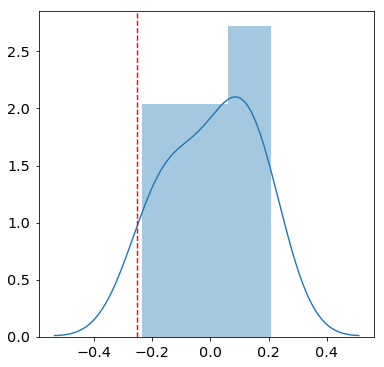

In [25]:
roi = 'Right-Accumbens-area'
pylab.rcParams['figure.figsize'] = 6, 6
sns.distplot(perm_dist_dict[1.0][roi])#, hist=False, rug=True)
pylab.axvline( float(roi_means_by_dist[1.0][roi]), c = 'red', linestyle='--')

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


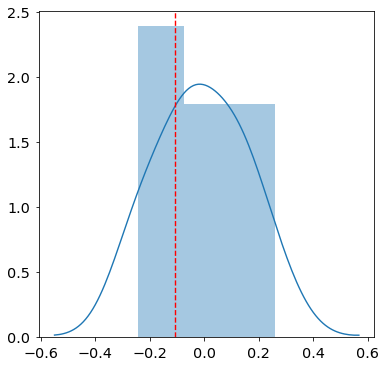

In [26]:
roi = 'Left-Accumbens-area'
pylab.rcParams['figure.figsize'] = 6, 6
sns.distplot(perm_dist_dict[1.0][roi])#, hist=False, rug=True)
pylab.axvline( float(roi_means_by_dist[1.0][roi]), c = 'red', linestyle='--')



### Summing up

Hopefully, this tutorial has given you a sense of the basics of working with and visualizing social network data, and relating features of that data (e.g., geodesic distance between nodes) to other characteristics (e.g., neural response time series similarities).